In [10]:
import librosa
import librosa.display
import os
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D,AveragePooling2D,ZeroPadding2D,BatchNormalization

In [2]:
y, sr = librosa.load('/home/daniel/datatest/nine/d8ee4734_nohash_0.wav',sr=16000,duration=10)

In [3]:
plt.figure()
plt.subplot(3, 1, 1)
librosa.display.waveplot(y, sr=sr)
plt.title('Monophonic')

In [4]:
plt.figure(figsize=(12, 8))
D = librosa.amplitude_to_db(librosa.stft(y), ref=np.max)
plt.subplot(4, 2, 1)
librosa.display.specshow(D, y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title('Linear-frequency power spectrogram')

/home/daniel/anaconda/lib/python2.7/site-packages/librosa/core/spectrum.py:958: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(magphase(D)[0]) instead.
  warnings.warn('amplitude_to_db was called on complex input so phase '


In [5]:
plt.subplot(4, 2, 2)
librosa.display.specshow(D, y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Log-frequency power spectrogram')

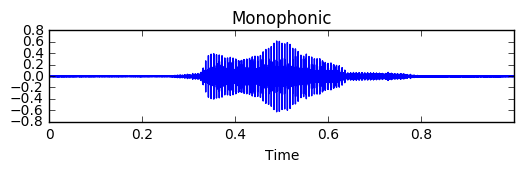

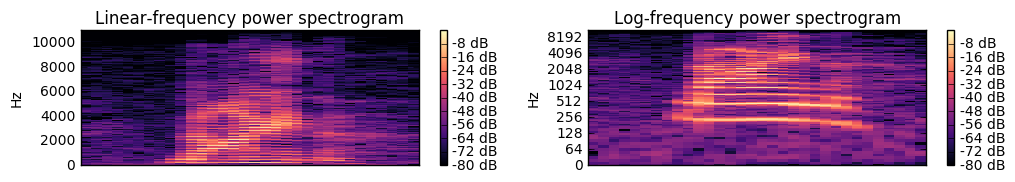

In [6]:
plt.show()

In [11]:
DATA_PATH = "/home/daniel/data/"

In [12]:
hop_length = 320

## LOAD DATA

In [13]:
import numpy as np
import os

DATA_PATH = "/home/daniel/data/"

# Input: Folder Path
# Output: Tuple (Label, Indices of the labels, one-hot encoded labels)
def get_labels(path=DATA_PATH):
    labels = os.listdir(path)
    label_indices = np.arange(0, len(labels))
    return labels, label_indices, to_categorical(label_indices)


In [14]:
labels, _, _ = get_labels(DATA_PATH)
labels

['marvin',
 'happy',
 'six',
 'up',
 'stop',
 'yes',
 'sheila',
 'zero',
 'dog',
 'right',
 'house',
 'no',
 'two',
 'left',
 'cat',
 'nine',
 'seven',
 'three',
 'wow',
 'bed']

## CONVERT WAV TO MFCC

In [15]:
# Handy function to convert wav2mfcc
def wav2mfcc(file_path, max_len=11):
    wave, sr = librosa.load(file_path, mono=True, sr=None)
    wave = wave[::3] #downsampling, 
    mfcc = librosa.feature.mfcc(wave,hop_length=hop_length, sr=16000,n_mfcc=20,n_fft=int(16000*0.04))

    # If maximum length exceeds mfcc lengths then pad the remaining ones
    if (max_len > mfcc.shape[1]):
        pad_width = max_len - mfcc.shape[1]
        mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')

    # Else cutoff the remaining parts
    else:
        mfcc = mfcc[:, :max_len]
    
    return mfcc

## SAVE DATA TO FILE NPY

In [16]:
def save_data_to_array(path=DATA_PATH, max_len=11):
    labels, _, _ = get_labels(path)

    for label in labels:
        # Init mfcc vectors
        mfcc_vectors = []

        wavfiles = [path + label + '/' + wavfile for wavfile in os.listdir(path + '/' + label)]
        for wavfile in wavfiles:
            mfcc = wav2mfcc(wavfile, max_len=max_len)
            mfcc_vectors.append(mfcc)
        np.save(label + '.npy', mfcc_vectors)

## SET PROPORTION FOR DATA TRAINING AND DATA TESTING

In [17]:
def get_train_test(split_ratio=0.8, random_state=42):
    # Get available labels
    labels, indices, _ = get_labels(DATA_PATH)

    # Getting first arrays
    X = np.load(labels[0] + '.npy')
    y = np.zeros(X.shape[0])

    # Append all of the dataset into one single array, same goes for y
    for i, label in enumerate(labels[1:]):
        x = np.load(label + '.npy')
        X = np.vstack((X, x))
        y = np.append(y, np.full(x.shape[0], fill_value= (i + 1)))
        print label
    assert X.shape[0] == len(y)

    return train_test_split(X, y, test_size= (1 - split_ratio), random_state=random_state, shuffle=True)

## SET HYPER PARAMETER FOR MODEL

In [18]:

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D,Conv1D
from keras.utils import to_categorical

# Second dimension of the feature is dim2
feature_dim_2 = 11

# Save data to array file first
save_data_to_array(max_len=feature_dim_2)

# # Loading train set and test set
X_train, X_test, y_train, y_test = get_train_test()

# # Feature dimension
feature_dim_1 = 20
channel = 1
epochs = 25
batch_size = 100
verbose = 1
num_classes = 20

# Reshaping to perform 2D convolution
X_train = X_train.reshape(X_train.shape[0], feature_dim_1, feature_dim_2, channel)
X_test = X_test.reshape(X_test.shape[0], feature_dim_1, feature_dim_2, channel)

y_train_hot = to_categorical(y_train)
y_test_hot = to_categorical(y_test)

happy
six
up
stop
yes
sheila
zero
dog
right
house
no
two
left
cat
nine
seven
three
wow
bed


In [19]:
# Predicts one sample
def predict(filepath, model):
    sample = wav2mfcc(filepath)
    sample_reshaped = sample.reshape(1, feature_dim_1, feature_dim_2, channel)
    return get_labels()[0][
            np.argmax(model.predict(sample_reshaped))
    ]

In [63]:
len(X_test)

6800

In [66]:
count = 0
for i in range(0,6800):
    sample = X_test[i].reshape(1, feature_dim_1, feature_dim_2, channel)
    prediction = get_labels()[0][np.argmax(model.predict(sample))]
    real = get_labels()[0][np.argmax(y_test_hot[i])]
    if (real == prediction):
        count+=1

In [71]:
from __future__ import division
count/6800

0.6410294117647058

In [62]:
sample = X_test[3].reshape(1, feature_dim_1, feature_dim_2, channel)
get_labels()[0][np.argmax(model.predict(sample))]

'left'

In [60]:
get_labels()[0][
            np.argmax(y_test_hot[2])
    ]

'marvin'

## INTIALIZE MODEL LENET ARCHITECTURE

In [22]:
def model_lenet():
    model = Sequential()
    model.add(Conv2D(20, kernel_size=(5, 5), strides=1, activation='relu', input_shape=(feature_dim_1, feature_dim_2, channel)))
    model.add(MaxPooling2D(pool_size=(2, 2),strides=2))
    model.add(ZeroPadding2D(padding=(2,2)))
    model.add(Conv2D(50, kernel_size=(5, 5),strides=1, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2),strides=2))
    model.add(Flatten())
    model.add(Dense(500, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    return model



In [23]:
model = model_lenet()
model.fit(X_train, y_train_hot, batch_size=batch_size, epochs=epochs, verbose=verbose, validation_data=(X_test, y_test_hot))

Train on 27200 samples, validate on 6800 samples
Epoch 1/25
27200/27200 [==============================] - 10s 382us/step - loss: 2.5061 - acc: 0.2562 - val_loss: 1.8247 - val_acc: 0.4194
Epoch 2/25
27200/27200 [==============================] - 10s 368us/step - loss: 1.5862 - acc: 0.4986 - val_loss: 1.5114 - val_acc: 0.5241
Epoch 3/25
27200/27200 [==============================] - 10s 350us/step - loss: 1.2972 - acc: 0.5867 - val_loss: 1.3996 - val_acc: 0.5662
Epoch 4/25
27200/27200 [==============================] - 8s 310us/step - loss: 1.1420 - acc: 0.6372 - val_loss: 1.2148 - val_acc: 0.6171
Epoch 5/25
27200/27200 [==============================] - 9s 341us/step - loss: 1.0300 - acc: 0.6699 - val_loss: 1.2424 - val_acc: 0.6160
Epoch 6/25
27200/27200 [==============================] - 9s 323us/step - loss: 0.9518 - acc: 0.6931 - val_loss: 1.1960 - val_acc: 0.6354
Epoch 7/25
27200/27200 [==============================] - 9s 319us/step - loss: 0.8766 - acc: 0.7156 - val_loss: 1.1383 

## INITIALIZE MODEL LENET WITH KERNEL WITH 2x2 KERNEL

In [20]:
def model_lenet_modk2():
    model = Sequential()
    model.add(Conv2D(20, kernel_size=(2, 2), strides=1, activation='relu', input_shape=(feature_dim_1, feature_dim_2, channel)))
    model.add(MaxPooling2D(pool_size=(2, 2),strides=2))
    #model.add(ZeroPadding2D(padding=(2,2)))
    model.add(Conv2D(50, kernel_size=(2, 2),strides=1, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2),strides=2))
    model.add(Flatten())
    model.add(Dense(500, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    return model

In [21]:
model = model_lenet_modk2()
model.fit(X_train, y_train_hot, batch_size=batch_size, epochs=epochs, verbose=verbose, validation_data=(X_test, y_test_hot))

Train on 27200 samples, validate on 6800 samples
Epoch 1/25
27200/27200 [==============================] - 8s 288us/step - loss: 2.7210 - acc: 0.2949 - val_loss: 1.6983 - val_acc: 0.4704
Epoch 2/25
27200/27200 [==============================] - 6s 220us/step - loss: 1.4958 - acc: 0.5381 - val_loss: 1.3923 - val_acc: 0.5606
Epoch 3/25
27200/27200 [==============================] - 6s 231us/step - loss: 1.1695 - acc: 0.6301 - val_loss: 1.3367 - val_acc: 0.5837
Epoch 4/25
27200/27200 [==============================] - 6s 220us/step - loss: 0.9764 - acc: 0.6885 - val_loss: 1.2056 - val_acc: 0.6237
Epoch 5/25
27200/27200 [==============================] - 5s 196us/step - loss: 0.8300 - acc: 0.7326 - val_loss: 1.1588 - val_acc: 0.6446
Epoch 6/25
27200/27200 [==============================] - 6s 224us/step - loss: 0.7208 - acc: 0.7685 - val_loss: 1.1761 - val_acc: 0.6426
Epoch 7/25
27200/27200 [==============================] - 6s 202us/step - loss: 0.6169 - acc: 0.7999 - val_loss: 1.1854 - v

## INITIALIZE MODEL LENET WITH KERNEL WITH 3x3 KERNEL

In [24]:
def model_lenet_modk3():
    model = Sequential()
    model.add(Conv2D(20, kernel_size=(3, 3), strides=1, activation='relu', input_shape=(feature_dim_1, feature_dim_2, channel)))
    model.add(MaxPooling2D(pool_size=(2, 2),strides=2))
    #model.add(ZeroPadding2D(padding=(2,2)))
    model.add(Conv2D(50, kernel_size=(3, 3),strides=1, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2),strides=2))
    model.add(Flatten())
    model.add(Dense(500, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    return model

In [25]:
model = model_lenet_modk3()
model.fit(X_train, y_train_hot, batch_size=batch_size, epochs=epochs, verbose=verbose, validation_data=(X_test, y_test_hot))

Train on 27200 samples, validate on 6800 samples
Epoch 1/25
27200/27200 [==============================] - 6s 210us/step - loss: 2.6542 - acc: 0.2377 - val_loss: 1.9767 - val_acc: 0.3754
Epoch 2/25
27200/27200 [==============================] - 6s 204us/step - loss: 1.7246 - acc: 0.4573 - val_loss: 1.5959 - val_acc: 0.4972
Epoch 3/25
27200/27200 [==============================] - 6s 238us/step - loss: 1.4375 - acc: 0.5469 - val_loss: 1.4353 - val_acc: 0.5493
Epoch 4/25
27200/27200 [==============================] - 6s 210us/step - loss: 1.2743 - acc: 0.5985 - val_loss: 1.4367 - val_acc: 0.5468
Epoch 5/25
27200/27200 [==============================] - 6s 226us/step - loss: 1.1570 - acc: 0.6361 - val_loss: 1.2742 - val_acc: 0.6025
Epoch 6/25
27200/27200 [==============================] - 6s 224us/step - loss: 1.0699 - acc: 0.6564 - val_loss: 1.3261 - val_acc: 0.5891
Epoch 7/25
27200/27200 [==============================] - 6s 224us/step - loss: 0.9969 - acc: 0.6801 - val_loss: 1.3066 - v

## INITIALIZE MODEL LENET WITH KERNEL WITH 4x4 KERNEL

In [30]:
def model_lenet_modk4():
    model = Sequential()
    model.add(Conv2D(20, kernel_size=(4, 4), strides=1, activation='relu', input_shape=(feature_dim_1, feature_dim_2, channel)))
    model.add(MaxPooling2D(pool_size=(2, 2),strides=2))
    model.add(ZeroPadding2D(padding=(2,2)))
    model.add(Conv2D(50, kernel_size=(4, 4),strides=1, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2),strides=2))
    model.add(Flatten())
    model.add(Dense(500, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    return model

In [31]:
model_k4 = model_lenet_modk4()
model_k4.fit(X_train, y_train_hot, batch_size=batch_size, epochs=epochs, verbose=verbose, validation_data=(X_test, y_test_hot))

Train on 27200 samples, validate on 6800 samples
Epoch 1/25
27200/27200 [==============================] - 12s 424us/step - loss: 6.6974 - acc: 0.1861 - val_loss: 1.9110 - val_acc: 0.4006
Epoch 2/25
27200/27200 [==============================] - 11s 403us/step - loss: 1.5055 - acc: 0.5257 - val_loss: 1.3200 - val_acc: 0.5853
Epoch 3/25
27200/27200 [==============================] - 11s 401us/step - loss: 1.1152 - acc: 0.6452 - val_loss: 1.1699 - val_acc: 0.6278
Epoch 4/25
27200/27200 [==============================] - 12s 424us/step - loss: 0.9266 - acc: 0.7060 - val_loss: 1.0503 - val_acc: 0.6726
Epoch 5/25
27200/27200 [==============================] - 10s 386us/step - loss: 0.7942 - acc: 0.7465 - val_loss: 1.0006 - val_acc: 0.6874
Epoch 6/25
27200/27200 [==============================] - 10s 359us/step - loss: 0.7023 - acc: 0.7729 - val_loss: 0.9827 - val_acc: 0.7029
Epoch 7/25
27200/27200 [==============================] - 10s 358us/step - loss: 0.6083 - acc: 0.8030 - val_loss: 1.0

## INITIALIZE MODEL LENET WITH KERNEL WITH 6x6 KERNEL

In [33]:
def model_lenet_modk6():
    model = Sequential()
    model.add(Conv2D(20, kernel_size=(6, 6), strides=1, activation='relu', input_shape=(feature_dim_1, feature_dim_2, channel)))
    model.add(MaxPooling2D(pool_size=(2, 2),strides=2))
    model.add(ZeroPadding2D(padding=(2,2)))
    model.add(Conv2D(50, kernel_size=(6, 6),strides=1, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2),strides=2))
    model.add(Flatten())
    model.add(Dense(500, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    return model

In [34]:
model = model_lenet_modk6()
model.fit(X_train, y_train_hot, batch_size=batch_size, epochs=epochs, verbose=verbose, validation_data=(X_test, y_test_hot))

Train on 27200 samples, validate on 6800 samples
Epoch 1/25
27200/27200 [==============================] - 9s 317us/step - loss: 2.5569 - acc: 0.2752 - val_loss: 1.7079 - val_acc: 0.4607
Epoch 2/25
27200/27200 [==============================] - 9s 344us/step - loss: 1.4366 - acc: 0.5481 - val_loss: 1.3788 - val_acc: 0.5631
Epoch 3/25
27200/27200 [==============================] - 9s 333us/step - loss: 1.1243 - acc: 0.6432 - val_loss: 1.0910 - val_acc: 0.6569
Epoch 4/25
27200/27200 [==============================] - 9s 339us/step - loss: 0.9662 - acc: 0.6918 - val_loss: 0.9812 - val_acc: 0.6953
Epoch 5/25
27200/27200 [==============================] - 9s 329us/step - loss: 0.8591 - acc: 0.7247 - val_loss: 0.9525 - val_acc: 0.7084
Epoch 6/25
27200/27200 [==============================] - 10s 372us/step - loss: 0.7822 - acc: 0.7492 - val_loss: 0.9913 - val_acc: 0.7065
Epoch 7/25
27200/27200 [==============================] - 9s 347us/step - loss: 0.7162 - acc: 0.7671 - val_loss: 1.0275 - 

## INITIALIZE MODEL SPNET

In [71]:
def model_spnet():
    model = Sequential()
    model.add(Conv2D(20, kernel_size=(5, 5), activation='relu',strides=4, input_shape=(feature_dim_1, feature_dim_2, channel)))
    model.add(ZeroPadding2D(padding=(2,2)))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(ZeroPadding2D(padding=(2,2)))
    model.add(Conv2D(50, kernel_size=(5, 5), activation='relu'))
    model.add(ZeroPadding2D(padding=(2,2)))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(ZeroPadding2D(padding=(2,2)))
    model.add(Conv2D(50, kernel_size=(5, 5), strides=1, activation='relu'))
    model.add(ZeroPadding2D(padding=(2,2)))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Flatten())
    model.add(Dense(200, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    return model



In [72]:
model = model_spnet()
model.fit(X_train, y_train_hot, batch_size=batch_size, epochs=epochs, verbose=verbose, validation_data=(X_test, y_test_hot))

Train on 27200 samples, validate on 6800 samples
Epoch 1/25
27200/27200 [==============================] - 10s 367us/step - loss: 2.5451 - acc: 0.2079 - val_loss: 2.0801 - val_acc: 0.3449
Epoch 2/25
27200/27200 [==============================] - 9s 334us/step - loss: 1.8483 - acc: 0.4030 - val_loss: 1.7280 - val_acc: 0.4356
Epoch 3/25
27200/27200 [==============================] - 8s 276us/step - loss: 1.6065 - acc: 0.4802 - val_loss: 1.5908 - val_acc: 0.4832
Epoch 4/25
27200/27200 [==============================] - 7s 271us/step - loss: 1.4647 - acc: 0.5252 - val_loss: 1.5646 - val_acc: 0.4972
Epoch 5/25
27200/27200 [==============================] - 8s 307us/step - loss: 1.3688 - acc: 0.5546 - val_loss: 1.5140 - val_acc: 0.5099
Epoch 6/25
27200/27200 [==============================] - 9s 339us/step - loss: 1.2890 - acc: 0.5788 - val_loss: 1.4851 - val_acc: 0.5238
Epoch 7/25
27200/27200 [==============================] - 11s 400us/step - loss: 1.2273 - acc: 0.5992 - val_loss: 1.4977 -

In [2]:
spnet = {}
lenet = {}
lenet_k2 = {}
lenet_k3 = {}
lenet_k4 = {}
lenet_k6 = {}

In [3]:
spnet[1] = 0.1925; spnet[5] = 0.5321; spnet[10] = 0.6224; spnet[15] = 0.6840; spnet[20] = 0.7310; spnet[25] = 0.7716; 

In [4]:
lenet[1] = 0.1035; lenet[5] = 0.6457; lenet[10] = 0.7575; lenet[15] = 0.8428; lenet[20] = 0.9051; lenet[25] = 0.9439; 

In [5]:
lenet_k2[1] = 0.0471; lenet_k2[5] = 0.5822; lenet_k2[10] = 0.7968; lenet_k2[15] = 0.9081; lenet_k2[20] = 0.9652; lenet_k2[25] = 0.9882; 

In [6]:
lenet_k3[1] = 0.1176; lenet_k3[5] = 0.6073; lenet_k3[10] = 0.7173; lenet_k3[15] = 0.7956; lenet_k3[20] = 0.8569; lenet_k3[25] = 0.9057; 

In [7]:
lenet_k4[1] = 0.1103; lenet_k4[5] = 0.7266; lenet_k4[10] = 0.8581; lenet_k4[15] = 0.9350; lenet_k4[20] = 0.9717; lenet_k4[25] = 0.9854; 

In [8]:
lenet_k6[1] = 0.0772; lenet_k6[5] = 0.7003; lenet_k6[10] = 0.8144; lenet_k6[15] = 0.8785; lenet_k6[20] = 0.9266; lenet_k6[25] = 0.9577; 

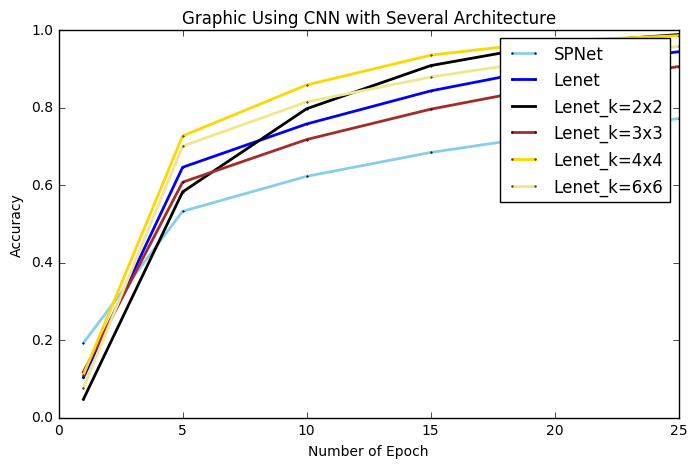

In [9]:
# Data
df=pd.DataFrame({'x': spnet.keys(), 'SPNet': spnet.values(), 'Lenet': lenet.values(), 'Lenet_k=2x2':lenet_k2.values(), 'Lenet_k=3x3':lenet_k3.values(), 'Lenet_k=4x4':lenet_k4.values(), 'Lenet_k=6x6':lenet_k6.values()})
 
# multiple line plot
plt.figure(figsize=(8,5))
plt.plot( 'x', 'SPNet', data=df, marker='o', markerfacecolor='blue', markersize=1, color='skyblue', linewidth=2)
plt.plot( 'x', 'Lenet', data=df, marker='o', markerfacecolor='blue', markersize=1, color='blue', linewidth=2)
plt.plot( 'x', 'Lenet_k=2x2', data=df, marker='o', markerfacecolor='black', markersize=1, color='black', linewidth=2)
plt.plot( 'x', 'Lenet_k=3x3', data=df, marker='o', markerfacecolor='brown', markersize=1, color='brown', linewidth=2)
plt.plot( 'x', 'Lenet_k=4x4', data=df, marker='o', markerfacecolor='gold', markersize=1, color='gold', linewidth=2)
plt.plot( 'x', 'Lenet_k=6x6', data=df, marker='o', markerfacecolor='khaki', markersize=1, color='khaki', linewidth=2)
plt.title('Graphic Using CNN with Several Architecture')
plt.xlabel('Number of Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [14]:
tabel_acc20 = pd.DataFrame([spnet.keys(),spnet.values(),lenet.values(),lenet_k2.values(),lenet_k3.values(),lenet_k4.values(),lenet_k6.values()])
tabel_acc20 = tabel_acc20.T
tabel_acc20.columns = ['number of epoch','SPNet','Lenet','Lenet k=2x2','Lenet k=3x3','Lenet k=4x4','Lenet k=6x6']
tabel_acc20_val = pd.DataFrame([0.5524,0.6581,0.6881,0.6368,0.7310,0.7229])
tabel_acc20_val = tabel_acc20_val.T
tabel_acc20_val.columns = ['SPNet','Lenet','Lenet k=2x2','Lenet k=3x3','Lenet k=4x4','Lenet k=6x6']

## MODEL ACCURATION FOR KOEFISIEN 20

In [15]:
tabel_acc20

,number of epoch,SPNet,Lenet,Lenet k=2x2,Lenet k=3x3,Lenet k=4x4,Lenet k=6x6
0,1.0,0.1925,0.1035,0.0471,0.1176,0.1103,0.0772
1,5.0,0.5321,0.6457,0.5822,0.6073,0.7266,0.7003
2,10.0,0.6224,0.7575,0.7968,0.7173,0.8581,0.8144
3,15.0,0.6840,0.8428,0.9081,0.7956,0.9350,0.8785
4,20.0,0.7310,0.9051,0.9652,0.8569,0.9717,0.9266
5,25.0,0.7716,0.9439,0.9882,0.9057,0.9854,0.9577


## VALIDATION ACCURATION FOR COEFFICIENT 20

In [16]:
tabel_acc20_val

,SPNet,Lenet,Lenet k=2x2,Lenet k=3x3,Lenet k=4x4,Lenet k=6x6
0,0.5524,0.6581,0.6881,0.6368,0.731,0.7229


In [17]:
spnet13 = {}
lenet13 = {}
lenet13_k2 = {}
lenet13_k3 = {}
lenet13_k4 = {}
lenet13_k6 = {}

In [18]:
spnet13[1] = 0.2054; spnet13[5] = 0.5474; spnet13[10] = 0.6310; spnet13[15] = 0.6905; spnet13[20] = 0.7459; spnet13[25] = 0.7872; 

In [19]:
lenet13[1] = 0.1330; lenet13[5] = 0.6335; lenet13[10] = 0.7281; lenet13[15] = 0.7885; lenet13[20] = 0.8375; lenet13[25] = 0.8782; 

In [20]:
lenet13_k2[1] = 0.1200; lenet13_k2[5] = 0.6473; lenet13_k2[10] = 0.7747; lenet13_k2[15] = 0.8563; lenet13_k2[20] = 0.9197; lenet13_k2[25] = 0.9578; 

In [21]:
lenet13_k3[1] = 0.1149; lenet13_k3[5] = 0.5739; lenet13_k3[10] = 0.6649; lenet13_k3[15] = 0.7171; lenet13_k3[20] = 0.7602; lenet13_k3[25] = 0.7996; 

In [22]:
lenet13_k4[1] = 0.1575; lenet13_k4[5] = 0.7296; lenet13_k4[10] = 0.8484; lenet13_k4[15] = 0.9227; lenet13_k4[20] = 0.9626; lenet13_k4[25] = 0.9781; 

In [23]:
lenet13_k6[1] = 0.1242; lenet13_k6[5] = 0.6913; lenet13_k6[10] = 0.7723; lenet13_k6[15] = 0.8182; lenet13_k6[20] = 0.8587; lenet13_k6[25] = 0.8940; 

In [24]:
tabel_acc13 = pd.DataFrame([spnet13.keys(),spnet13.values(),lenet13.values(),lenet13_k2.values(),lenet13_k3.values(),lenet13_k4.values(),lenet13_k6.values()])
tabel_acc13 = tabel_acc13.T
tabel_acc13.columns = ['number of epoch','SPNet','Lenet','Lenet k=2x2','Lenet k=3x3','Lenet k=4x4','Lenet k=6x6']
tabel_acc13_val = pd.DataFrame([0.5510,0.6584,0.6688,0.6309,0.7249,0.7328])
tabel_acc13_val = tabel_acc13_val.T
tabel_acc13_val.columns = ['SPNet','Lenet','Lenet k=2x2','Lenet k=3x3','Lenet k=4x4','Lenet k=6x6']

## MODEL ACCURATION FOR COEFFICIENT 13

In [25]:
tabel_acc13

,number of epoch,SPNet,Lenet,Lenet k=2x2,Lenet k=3x3,Lenet k=4x4,Lenet k=6x6
0,1.0,0.2054,0.1330,0.1200,0.1149,0.1575,0.1242
1,5.0,0.5474,0.6335,0.6473,0.5739,0.7296,0.6913
2,10.0,0.6310,0.7281,0.7747,0.6649,0.8484,0.7723
3,15.0,0.6905,0.7885,0.8563,0.7171,0.9227,0.8182
4,20.0,0.7459,0.8375,0.9197,0.7602,0.9626,0.8587
5,25.0,0.7872,0.8782,0.9578,0.7996,0.9781,0.8940


## VALIDATION ACCURATION FOR COEFFICIENT 13

In [28]:
tabel_acc13_val

,SPNet,Lenet,Lenet k=2x2,Lenet k=3x3,Lenet k=4x4,Lenet k=6x6
0,0.551,0.6584,0.6688,0.6309,0.7249,0.7328


In [29]:
spnet26 = {}
lenet26 = {}
lenet26_k2 = {}
lenet26_k3 = {}
lenet26_k4 = {}
lenet26_k6 = {}

In [30]:
spnet26[1] = 0.1608; spnet26[5] = 0.5356; spnet26[10] = 0.6292; spnet26[15] = 0.6981; spnet26[20] = 0.7518; spnet26[25] = 0.7979; 

In [31]:
lenet26[1] = 0.1394; lenet26[5] = 0.6662; lenet26[10] = 0.7792; lenet26[15] = 0.8564; lenet26[20] = 0.9193; lenet26[25] = 0.9544;

In [32]:
lenet26_k2[1] = 0.0505; lenet26_k2[5] = 0.0673; lenet26_k2[10] = 0.7280; lenet26_k2[15] = 0.8785; lenet26_k2[20] = 0.9635; lenet26_k2[25] = 0.9870; 

In [33]:
lenet26_k3[1] = 0.1163; lenet26_k3[5] = 0.6145; lenet26_k3[10] = 0.7428; lenet26_k3[15] = 0.8334; lenet26_k3[20] = 0.9082; lenet26_k3[25] = 0.9535; 

In [34]:
lenet26_k4[1] = 0.0889; lenet26_k4[5] = 0.7350; lenet26_k4[10] = 0.8754;  lenet26_k4[15] = 0.9542;  lenet26_k4[20] = 0.9814;  lenet26_k4[25] = 0.9907;

In [35]:
lenet26_k6[1] = 0.1848; lenet26_k6[5] = 0.7191; lenet26_k6[10] = 0.8240; lenet26_k6[15] = 0.8906; lenet26_k6[20] = 0.9380; lenet26_k6[25] = 0.9629; 

In [36]:
tabel_acc26 = pd.DataFrame([spnet26.keys(),spnet26.values(),lenet26.values(),lenet26_k2.values(),lenet26_k3.values(),lenet26_k4.values(),lenet26_k6.values()])
tabel_acc26 = tabel_acc26.T
tabel_acc26.columns = ['number of epoch','SPNet','Lenet','Lenet k=2x2','Lenet k=3x3','Lenet k=4x4','Lenet k=6x6']
tabel_acc26_val = pd.DataFrame([0.5524,0.6669,0.6825,0.6293,0.7400,0.7207])
tabel_acc26_val = tabel_acc26_val.T
tabel_acc26_val.columns = ['SPNet','Lenet','Lenet k=2x2','Lenet k=3x3','Lenet k=4x4','Lenet k=6x6']

## MODEL ACCURATION FOR COEFFICIENT 26

In [37]:
tabel_acc26

,number of epoch,SPNet,Lenet,Lenet k=2x2,Lenet k=3x3,Lenet k=4x4,Lenet k=6x6
0,1.0,0.1608,0.1394,0.0505,0.1163,0.0889,0.1848
1,5.0,0.5356,0.6662,0.0673,0.6145,0.7350,0.7191
2,10.0,0.6292,0.7792,0.7280,0.7428,0.8754,0.8240
3,15.0,0.6981,0.8564,0.8785,0.8334,0.9542,0.8906
4,20.0,0.7518,0.9193,0.9635,0.9082,0.9814,0.9380
5,25.0,0.7979,0.9544,0.9870,0.9535,0.9907,0.9629


## VALIDATION ACCURATION FOR COEFFICIENT 26

In [38]:
tabel_acc26_val

,SPNet,Lenet,Lenet k=2x2,Lenet k=3x3,Lenet k=4x4,Lenet k=6x6
0,0.5524,0.6669,0.6825,0.6293,0.74,0.7207


In [11]:
sp_graph = {}
lenet_graph = {}
lenet2_graph = {}
lenet3_graph = {}
lenet4_graph = {}
lenet6_graph = {}
sp_graph[13] = 0.551; lenet_graph[13] = 0.6584; lenet2_graph[13] = 0.6688; lenet3_graph[13] = 0.6309; lenet4_graph[13] = 0.7249; lenet6_graph[13] = 0.7328;
sp_graph[20] = 0.5524; lenet_graph[20] = 0.6581; lenet2_graph[20] = 0.6881; lenet3_graph[20] = 0.6368; lenet4_graph[20] = 0.731; lenet6_graph[20] = 0.7229;
sp_graph[26] = 0.5524; lenet_graph[26] = 0.6669; lenet2_graph[26] = 0.6825; lenet3_graph[26] = 0.6293; lenet4_graph[26] = 0.74; lenet6_graph[26] = 0.7207;

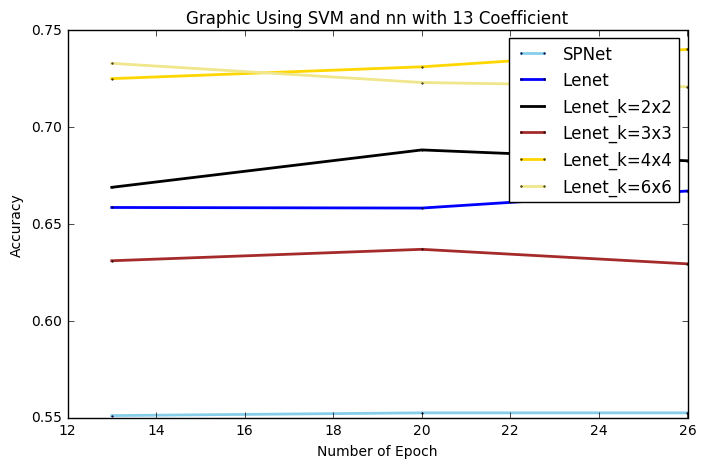

In [12]:
# Data
df=pd.DataFrame({'x': sp_graph.keys(), 'SPNet': sp_graph.values(), 'Lenet': lenet_graph.values(), 'Lenet_k=2x2':lenet2_graph.values(), 'Lenet_k=3x3':lenet3_graph.values(), 'Lenet_k=4x4':lenet4_graph.values(), 'Lenet_k=6x6':lenet6_graph.values()})
 
# multiple line plot
plt.figure(figsize=(8,5))
plt.plot( 'x', 'SPNet', data=df, marker='o', markerfacecolor='blue', markersize=1, color='skyblue', linewidth=2)
plt.plot( 'x', 'Lenet', data=df, marker='o', markerfacecolor='blue', markersize=1, color='blue', linewidth=2)
plt.plot( 'x', 'Lenet_k=2x2', data=df, marker='o', markerfacecolor='black', markersize=1, color='black', linewidth=2)
plt.plot( 'x', 'Lenet_k=3x3', data=df, marker='o', markerfacecolor='brown', markersize=1, color='brown', linewidth=2)
plt.plot( 'x', 'Lenet_k=4x4', data=df, marker='o', markerfacecolor='gold', markersize=1, color='gold', linewidth=2)
plt.plot( 'x', 'Lenet_k=6x6', data=df, marker='o', markerfacecolor='khaki', markersize=1, color='khaki', linewidth=2)
plt.title('Graphic Using SVM and nn with 13 Coefficient')
plt.xlabel('Number of Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

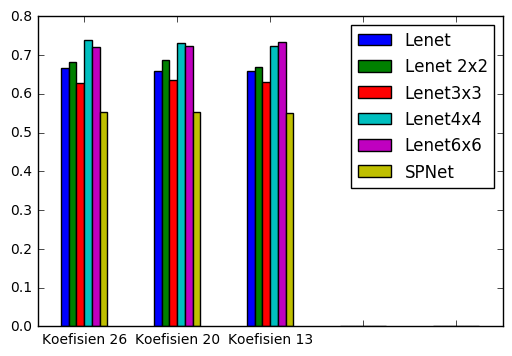

In [74]:
sp = [sp_graph[26],sp_graph[20],sp_graph[13],0,0]
le = [lenet_graph[26],lenet_graph[20],lenet_graph[13],0,0]
le2 = [lenet2_graph[26],lenet2_graph[20],lenet2_graph[13],0,0]
le3 = [lenet3_graph[26],lenet3_graph[20],lenet3_graph[13],0,0]
le4 = [lenet4_graph[26],lenet4_graph[20],lenet4_graph[13],0,0]
le6 = [lenet6_graph[26],lenet6_graph[20],lenet6_graph[13],0,0]
index = ["Koefisien 26",'Koefisien 20','Koefisien 13','','']
df = pd.DataFrame({'SPNet': sp,'Lenet': le,'Lenet 2x2': le2,'Lenet3x3': le3,'Lenet4x4': le4,'Lenet6x6': le6}, index=index)
ax = df.plot.bar(rot=0)
plt.show()

In [60]:
tp = {}
fp = {}
fn = {}

In [62]:
for i in labels:
    tp[i] = 0
    fp[i] = 0
    fn[i] = 0

In [63]:
count = 0
for i in range(0,6800):
    sample = X_test[i].reshape(1, feature_dim_1, feature_dim_2, channel)
    prediction = get_labels()[0][np.argmax(model_k4.predict(sample))]
    real = get_labels()[0][np.argmax(y_test_hot[i])]
    if (real == prediction):
        count+=1
        tp[real]+=1
    else:
        fn[prediction]+=1
        fp[real]+=1

In [74]:
precision = {}
recall = {}
f1 = {}
accurationn = {}
error_rate = {}
for i in labels:
    precision[i] = 0
    recall[i] = 0
    f1[i] = 0
    error_rate[i] = 0

In [75]:
from __future__ import division
for i in labels:
    precision[i] = tp[i]/(tp[i]+fp[i])
    recall[i] = tp[i]/(tp[i]+fn[i])
    f1[i] = 2*(precision[i]*recall[i])/(precision[i]+recall[i])
    error_rate[i] = 1-precision[i]

In [76]:
tabel_acc26_val = pd.DataFrame([precision.keys(),precision.values(),recall.values(),f1.values(),error_rate.values()])
tabel_acc26_val = tabel_acc26_val.T
tabel_acc26_val.columns = ['Label', 'Precision / Accuration', 'Recall', 'F - Measure','Error Rate']

## Confusion Matrix

In [77]:
tabel_acc26_val

,Label,Precision / Accuration,Recall,F - Measure,Error Rate
0,sheila,0.771875,0.732938,0.751903,0.228125
1,seven,0.558282,0.713725,0.626506,0.441718
2,right,0.718654,0.732087,0.725309,0.281346
3,three,0.789017,0.675743,0.728,0.210983
4,no,0.725212,0.616867,0.666667,0.274788
5,marvin,0.839286,0.824561,0.831858,0.160714
6,wow,0.767705,0.87987,0.81997,0.232295
7,six,0.65,0.764706,0.702703,0.35
8,stop,0.683646,0.676393,0.68,0.316354
9,up,0.801802,0.550515,0.652812,0.198198


## EXAMPLE PREDICTION OF VOICE 

In [87]:
print(predict('/home/daniel/data/zero/1c1060b1_nohash_1.wav', model=model_k4))

sheila
